In [1]:
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag
import plotly.express as px
import seaborn as sns
import numpy as np
from PIL import Image
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
# Read data into papers
papers = pd.read_csv('Data/raw_clean_data.csv')
# Print head
papers.head()

,text,rating,Label
0,beautiful accomodations stayed hotel santa mar...,4,Positive
1,great hotel great location hotel located la ra...,5,Positive
2,beautiful hotel great location like beautifull...,4,Positive
3,great deal waikiki trip hawaii outrigger luana...,4,Positive
4,choose airport hotel busy triparound australia...,1,Negative


In [3]:
papers['text'][0]

'beautiful accomodations stayed hotel santa maria novella night wished stayed entirety days florence simply gorgeous accomodations, room stayed cheapest rate available assuming simplest abode offer beautiful hardwood floors bed linens comfortable mattress difficult italy drapes fantastic marble bathroom, nicer expecting especially price, location not central 10-minute walk sights close train station away noise bustle busier locations, close upscale shopping lots trattorias, nice oasis hectic sightseeing florence highly recommed hotel hotels higher ranked website,  '

# Tokenization, Stopwords, Lemmatization

In [4]:
def process_doc(doc):

        #initialize lemmatizer
        wnl = WordNetLemmatizer()
        stop_words = stopwords.words('english')
        
        # helper function to change nltk's part of speech tagging to a wordnet format.
        def pos_tagger(nltk_tag):
            if nltk_tag.startswith('J'):
                return wordnet.ADJ
            elif nltk_tag.startswith('V'):
                return wordnet.VERB
            elif nltk_tag.startswith('N'):
                return wordnet.NOUN
            elif nltk_tag.startswith('R'):
                return wordnet.ADV
            else:         
                return None


        # remove stop words and punctuations, then lower case
        doc_norm = [tok.lower() for tok in word_tokenize(doc) if ((tok.isalpha()) & (tok.lower() not in stop_words)) ]

        #  POS detection on the result will be important in telling Wordnet's lemmatizer how to lemmatize

        # creates list of tuples with tokens and POS tags in wordnet format
        wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(doc_norm))) 
        doc_norm = [wnl.lemmatize(token, pos) for token, pos in wordnet_tagged if pos is not None]

        return " ".join(doc_norm)

In [5]:
papers['text'] = papers['text'].apply(process_doc)

In [6]:
papers['text'][0]

'beautiful accomodations stay hotel santa maria novella night wish stayed entirety day florence simply gorgeous accomodations room stay cheap rate available assume simple abode offer beautiful hardwood floor bed linens comfortable mattress difficult italy drape fantastic marble bathroom nicer expect especially price location central walk sight close train station away noise bustle busy location close upscale shopping lot trattorias nice oasis hectic sightsee florence highly recommed hotel hotel higher rank website'

# EDA 

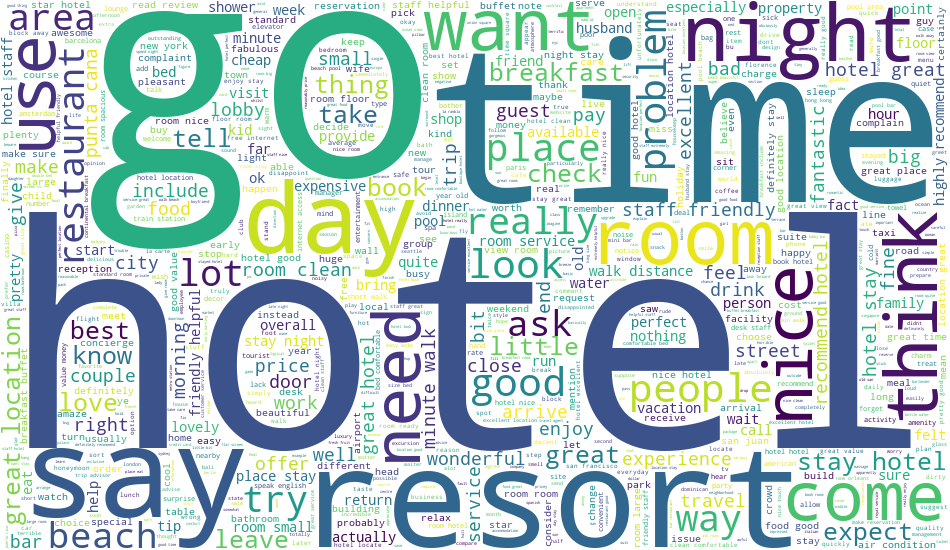

In [7]:


# Join the different processed titles together.
long_string = ','.join(list(papers['text'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white",width = 950, height = 550, max_words=5000)

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

In [8]:
mar_logo = np.array(Image.open('Data/Color-Marriott-logo.jpg'))

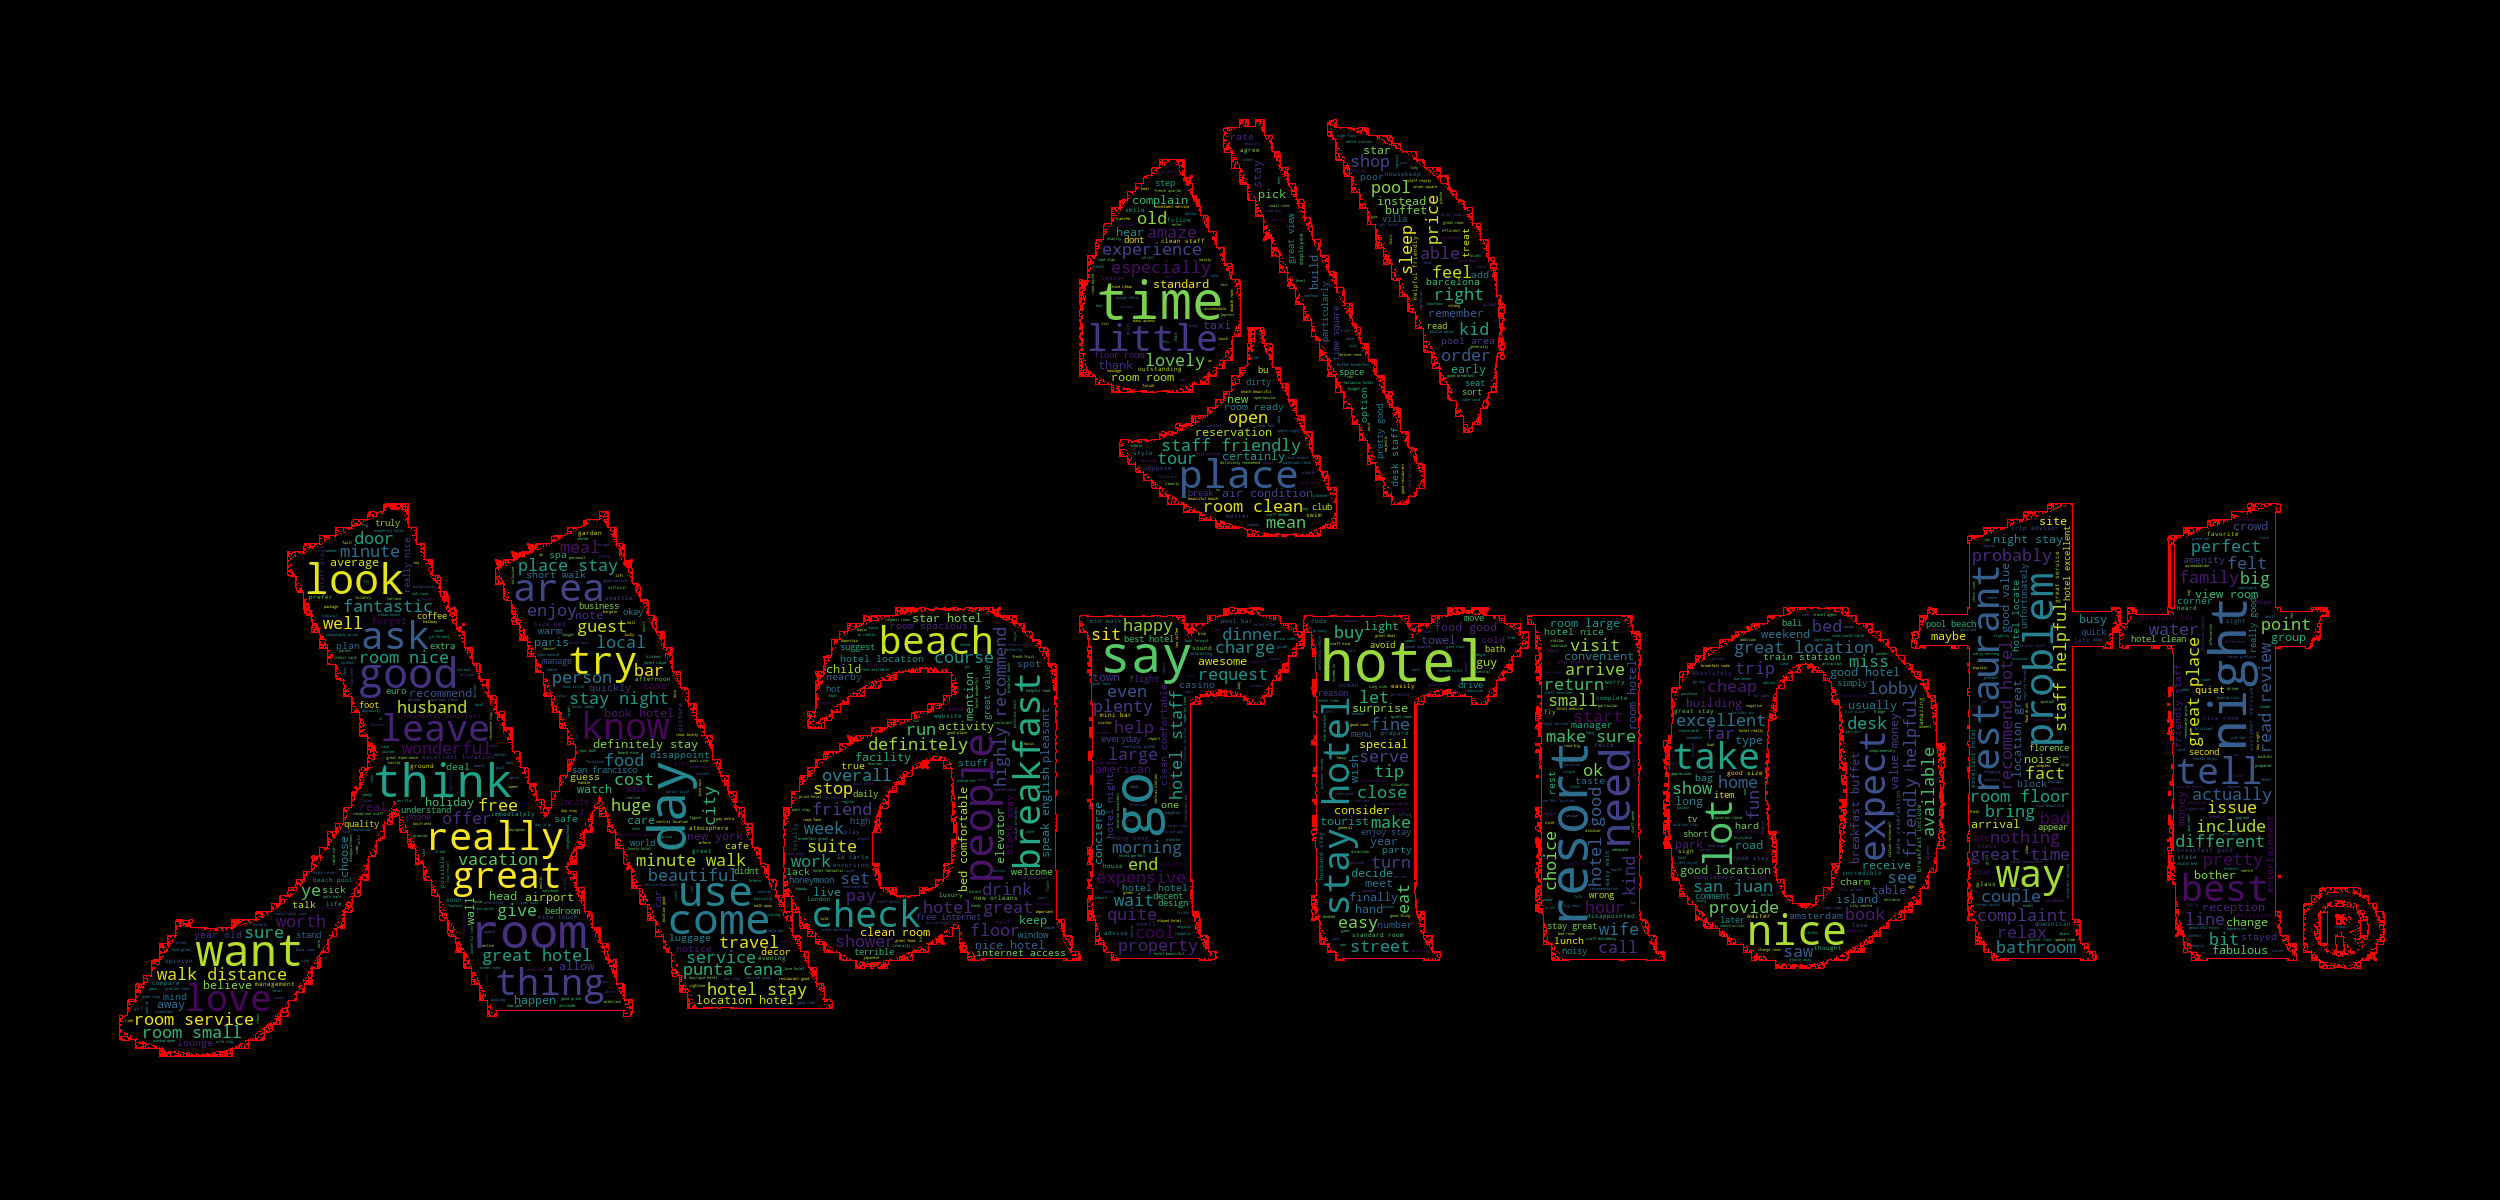

In [9]:
nwc = WordCloud(background_color="black", mask=mar_logo,width = 800, height = 500,
            contour_width=1, contour_color='red',max_words=10000)

# generate word cloud
nwc.generate(long_string)
nwc.to_image()

# Topic Modeling - Vectorization

In [10]:
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

In [11]:
corpus = papers['text']

In [12]:
vec = TfidfVectorizer()
X_train = vec.fit_transform(corpus)
X_train

<20491x41790 sparse matrix of type '<class 'numpy.float64'>'
	with 1470033 stored elements in Compressed Sparse Row format>

In [13]:
topic_model = NMF(n_components=5,max_iter=1000)
topic_model.fit(X_train)

NMF(max_iter=1000, n_components=5)

In [14]:
H = topic_model.transform(X_train)

W = topic_model.components_

print(f'Shape of W is {W.shape}')
print(f'Shape of H is {H.shape}')
print(f'Shape of X_train {X_train.shape}')

Shape of W is (5, 41790)
Shape of H is (20491, 5)
Shape of X_train (20491, 41790)


## The W Matrix

In [15]:
for index, topic in enumerate(W):
    print(f'The top 10 words for topic #{index}')
    print([vec.get_feature_names()[i] for i in topic.argsort()[-30:]])
    print('\n')

The top 10 words for topic #0
['nice', 'look', 'leave', 'come', 'arrive', 'bad', 'shower', 'work', 'give', 'go', 'door', 'service', 'time', 'bathroom', 'book', 'pay', 'small', 'tell', 'say', 'view', 'day', 'get', 'ask', 'floor', 'stay', 'check', 'desk', 'night', 'bed', 'room']


The top 10 words for topic #1
['make', 'say', 'nice', 'fun', 'kid', 'week', 'want', 'best', 'lot', 'trip', 'service', 'punta', 'cana', 'bar', 'get', 'buffet', 'water', 'beautiful', 'vacation', 'drink', 'restaurant', 'good', 'go', 'people', 'time', 'day', 'pool', 'food', 'beach', 'resort']


The top 10 words for topic #2
['highly', 'new', 'square', 'little', 'price', 'right', 'bed', 'breakfast', 'time', 'recommend', 'wonderful', 'value', 'night', 'really', 'fantastic', 'perfect', 'comfortable', 'definitely', 'love', 'nice', 'view', 'clean', 'helpful', 'friendly', 'place', 'room', 'staff', 'stay', 'location', 'great']


The top 10 words for topic #3
['love', 'feel', 'restaurant', 'year', 'star', 'definitely', 're

In [16]:
topic_name_dict = {0:'Guest_Experience_&_Interactions', 1:'Beach_Resort', 2:' Value_&_Comfort',
                   3:'Restaurant_Experience', 4:'City_Experience'}

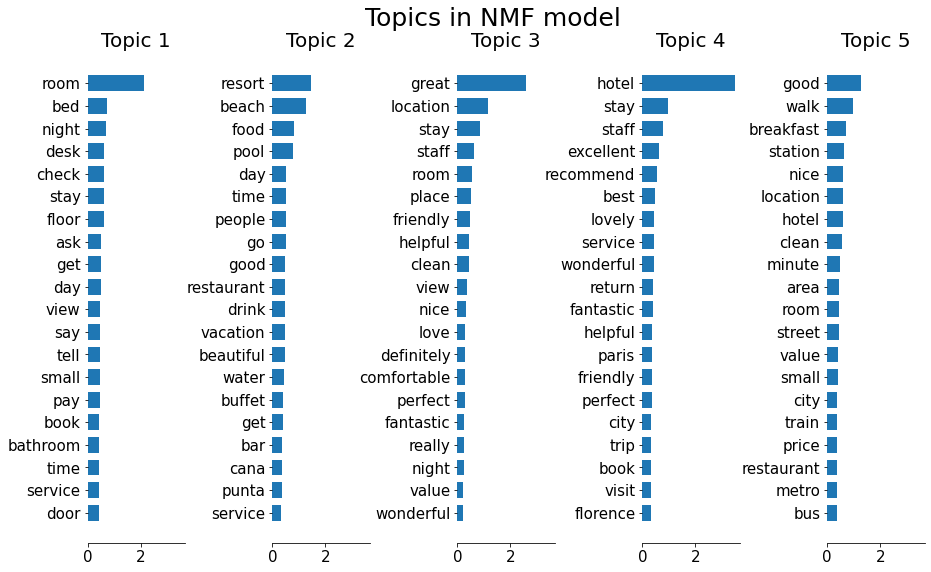

In [17]:
def plot_top_words(W, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 5, figsize=(15, 8), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(W):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 20})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=15)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=25)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

n_top_words = 20
tfidf_feature_names = vec.get_feature_names()
plot_top_words(W, tfidf_feature_names, n_top_words, "Topics in NMF model")

#### The H matrix

In [41]:
# takes in list of documents and plots topic weight vectors for each document
def review_topbreakdown(locator):

    print(papers.loc[locator].text)
    int_index = papers.index.get_loc(locator)

    topic_keys = topic_name_dict.values()
    zipped_tuple = list(zip(topic_keys, list(H[int_index,:])))

    topic_breakdown = pd.DataFrame(zipped_tuple, columns = ['Topic', 'Weight']).set_index(['Topic'])
    topic_breakdown['Normalized weight'] = topic_breakdown['Weight']/topic_breakdown['Weight'].sum()

    fig = px.bar(topic_breakdown, y = topic_breakdown.index, x = 'Normalized weight', 
                 title = ("Distribution of topics for review no. " + str(locator)), color = topic_breakdown.index )
    fig.show()
    return topic_breakdown
    

In [42]:
review_topbreakdown(4)

choose airport hotel busy triparound australia arrive place rude receptionist corridor room look bombsite warning room mid expensive room service mini crazy air key fail shuttle driver miss drop wrong terminal


,Weight,Normalized weight
Topic,,
Guest_Experience_&_Interactions,0.028812,0.733197
Beach_Resort,0.000000,0.000000
Value_&_Comfort,0.000000,0.000000
Restaurant_Experience,0.005950,0.151402
City_Experience,0.004535,0.115401


In [43]:
review_loc_list = [4,663,100, 720]
g = list(map(review_topbreakdown, review_loc_list))


choose airport hotel busy triparound australia arrive place rude receptionist corridor room look bombsite warning room mid expensive room service mini crazy air key fail shuttle driver miss drop wrong terminal


nickel dime death start state love new orleans time stayed location trip stay true holiday inn brand try use hotel highly recomend find different hotel chateau lemoyne city way way extract money pocket turn dollar night park suv opt tell phone size park space way money charge use business read bunch complaint park charge reviewer hotel obviously aware staff sickly sweet sell public parking use hotel room plenty crack plaster mark wall trim charm poorly time drury chance


right hotel group adult come june july impression great stayed club section welcome bell boys helpfull get drink weather boiling week get burnt use high factor didnt expect room block call refurbish one impression great flatscreen tv huge room nice bathroom start notice thing dont spilt bit bed night end week dont clean wardrobe door broken maid nothinf get people group pay saftry deposit box didnt work refund reset card reception night room change card didnt work good pool look beautiful look close stay club pool pool bar say main pool quite dirty see clean turkey time clean day everyday nothing little earwiggy thing pool u light inide pool hang sunloungers big group obviously earlier u well pick u want sit beach wow best see clear blue water white sand shade heaven walk hour right beach little market good experience tiering buy want good go little market reception beach keep fairly clean food drink great bad thing say food different eat repetitive waiter try hard tip couple one didnt

special care honeymooner stay night singapore end honeymoon malaysia comlimentary upgrade garden wing suite fabulous suite terrace sun lounger overlook beautiful swim pool palm tree fresh fruit cake happy honeymooner iced plate rise petal shape heart king size bed order room service food excellent service prompt fault really consider star hotel cost london wonderful experience star treatment fraction cost home definitely return hotel


# TSNE: A way to visualize our documents by topic in 2D

In [44]:
tsne = TSNE(random_state=42, learning_rate=100)
tsne_trans = tsne.fit_transform(H)
tsne_trans = pd.DataFrame(tsne_trans, columns = ['TSNE1', 'TSNE2'])

In [45]:
# for each document takes the topic with highest weight and assigns document to this class -- hard clustering.
tsne_trans['class'] = np.argmax(H, axis = 1)
tsne_trans['class'] = tsne_trans['class'].replace(topic_name_dict)

In [47]:

fig = px.scatter(tsne_trans, x = 'TSNE1', y = 'TSNE2', color = 'class', 
          title='Visualization of Hotel Review Topic Segmentation')

fig.update_traces(marker=dict(size=6.5,
                              line=dict(width=.2,
                                        color='Black')),
                  selector=dict(mode='markers'))
fig.show()

# Umap

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
tfidf_feature_names